In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics
from schmeud._schmeud import locality as schmeud_locality

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()
project: signac.Project = signac.get_project(root=config['root'])
project.doc

import gudhi
from gudhi import representations

In [ ]:
def get_grid(traj, frame, softness_df, n_bins=10, dims=(0), sample_range=(-2, 2), neg=False):
    # compute betti curves
    betti_curves = []
    betti = representations.vector_methods.BettiCurve(sample_range=sample_range).__call__
    unique_frames =  softness_df["frame"].unique()
    if frame not in unique_frames:
        raise ValueError(f"frame {frame} not in softness_df")
    snap = traj[int(frame)]
    points = snap.particles.position
    points = points[snap.particles.typeid == 0]
    l = snap.configuration.box[0]
    soft = softness_df[softness_df["frame"] == frame]["softness"].values.astype(np.float32)
    if neg:
        soft = -soft
    grid = schmeud_locality.particle_to_grid_cube_cic(points, soft, l, n_bins)
    return grid

def get_voro_neighb_and_soft(traj, frames, softness_df, neg=False):
    unique_frames =  softness_df["frame"].unique()
    voro = freud.locality.Voronoi()
    for frame in frames:
        if frame not in unique_frames:
            raise ValueError(f"frame {frame} not in softness_df")
        snap = traj[int(frame)]
        points = snap.particles.position
        points = points[snap.particles.typeid == 0]
        box = snap.configuration.box
        soft = softness_df[softness_df["frame"] == frame]["softness"].values.astype(np.float32)
        if neg:
            soft = -soft
        f

In [2]:
def grid_process_step1(grid, filt, periodic=True):

    tree = schmeud_locality.BlockTree(grid.astype(np.float32), periodic)

    output = tree.mass_and_msd(filt)
    return output

def plot_mass_and_msd_multi(scan_data, filtration, axs=None):
    cmap = cm.viridis
    norm = colors.Normalize(vmin=np.min(filtration), vmax=np.max(filtration))

    bins = np.geomspace(1e-1, 1e5, 20)

    ax_idx = None
    if axs is None:
        fig, ax = plt.subplots()
    else:
        if not isinstance(axs, plt.Axes):
            ax_idx = 0
        else:
            plt.sca(axs)
        

    for idx, val in enumerate(filtration):
        if ax_idx is not None:
            plt.sca(axs[ax_idx])
            ax_idx += 1
        res = []
        for data in scan_data:
            if len(data[idx]) == 0:
                continue
            res.append(np.array(data[idx]))
        if len(res) == 0:
            continue
        res = np.concatenate(res)
        # print(res.shape)
        # plt.scatter(res[:, 2], res[:, 3], color=cmap(norm(val)), s=40)
        # plt.hist2d(res[:, 2], res[:, 3], norm=mpl.colors.LogNorm(), cmap=cmap, bins=[bins, bins])
        sns.regplot(x=res[:, 2], y=res[:, 3], scatter_kws={"s": 10}, color=cmap(norm(val)), scatter=False, fit_reg=False, ax=plt.gca())
        # plt.scatter([val]*len(res), res[:, 3], color=cmap(norm(val)), s=40)
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.xlabel("Mass")
    # plt.ylabel(r"$\langle \left( x - x_{com} \right)^2 \rangle$")
    # plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="Softness level set")

def grid_process_step2(scan_data, filt, axs=None):
    plot_mass_and_msd_multi(scan_data, filt, axs=axs)

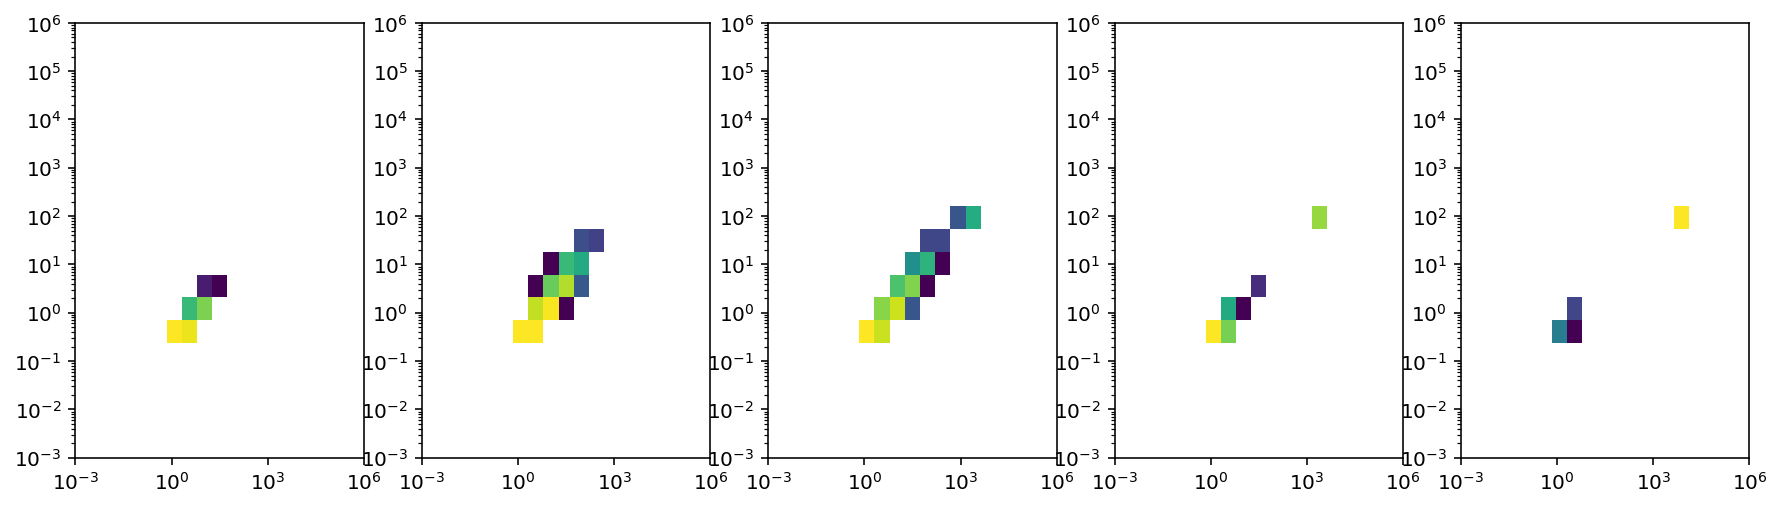

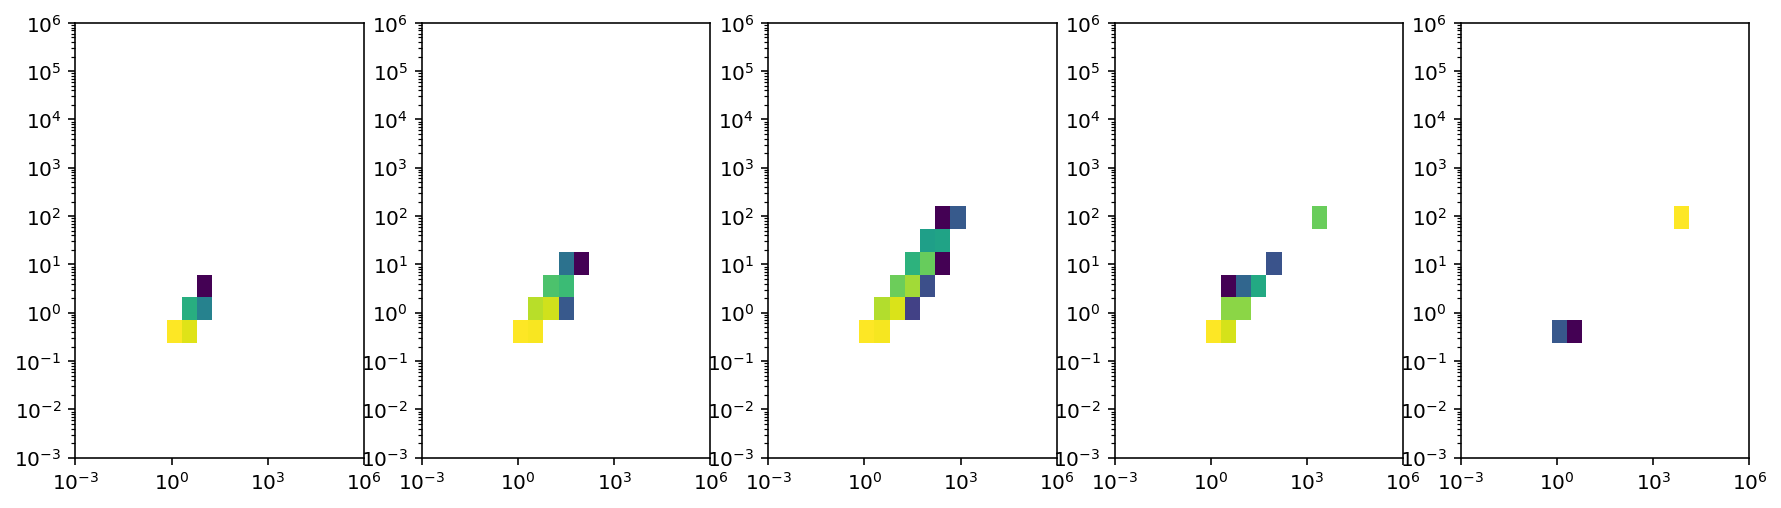

In [23]:
n_bins = 20
N = n_bins

output = defaultdict(list)

for delta, jobs_iter in project.find_jobs({"delta": 0.0}, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    job_bettis = []
    for job in jobs_iter:
        betti_curves = []
        temps = []
        for run_dir in sorted(glob.glob(job.fn("short_runs/temp-*"))):
            temp = float(utils.extract_between(run_dir, "temp-", "/"))
            # print(temp)
            if temp not in [0.47, 0.7]:
                continue
            temps.append(temp)
            # print(temps[-1])
            run_dir = pathlib.Path(run_dir)
            # get softness dfb
            softness_df = pd.read_parquet(run_dir / "struct-descr.parquet")
            # get traj
            traj = gsd.hoomd.open(run_dir / "traj.gsd")

            for frame in softness_df["frame"].unique():
                grid = get_grid(traj, frame, softness_df, n_bins=n_bins, dims=(0,1,2))
                assert(not np.isnan(grid).any())
                
                # print(np.min(grid), np.max(grid))
                # process_grid(grid, np.linspace(-1.0, 0.0, 5, dtype=np.float32), axs=axs)
                output[temp].append(grid_process_step1(grid, np.linspace(-1.0, 0.0, 5, dtype=np.float32), periodic=False))
            # ax.set_ylim(1e-1, 2e2)
            # ax.set_xlim(1, 1e4)
            # # break
            # ax.set_title(f"T={temp:.2f}")
        
    break


for k, v in output.items():
    fig, axs = plt.subplots(1, 5, figsize=(15, 4))
    grid_process_step2(v, np.linspace(-1.0, 0.0, 5, dtype=np.float32), axs=axs)
    for ax in axs:
        ax.set_xscale('log')
        ax.set_yscale('log')

In [11]:
import seaborn as sns

def plot_mass_and_msd_multi(scan_data, filtration, axs=None):
    cmap = cm.viridis
    norm = colors.Normalize(vmin=np.min(filtration), vmax=np.max(filtration))

    bins = np.geomspace(1e-1, 1e5, 20)

    ax_idx = None
    if axs is None:
        fig, ax = plt.subplots()
    else:
        if not isinstance(axs, plt.Axes):
            ax_idx = 0
        else:
            plt.sca(axs)
        

    for idx, val in enumerate(filtration):
        if ax_idx is not None:
            plt.sca(axs[ax_idx])
            ax_idx += 1
        res = []
        for data in scan_data:
            if len(data[idx]) == 0:
                continue
            res.append(np.array(data[idx]))
        if len(res) == 0:
            continue
        res = np.concatenate(res)
        # print(res.shape)
        # plt.scatter(res[:, 2], res[:, 3], color=cmap(norm(val)), s=40)
        # plt.hist2d(res[:, 2], res[:, 3], norm=mpl.colors.LogNorm(), cmap=cmap, bins=[bins, bins])
        sns.regplot(x=res[:, 2], y=res[:, 3], color=cmap(norm(val)), scatter=True, fit_reg=False, ax=plt.gca(), x_bins=bins)
        # plt.scatter([val]*len(res), res[:, 3], color=cmap(norm(val)), s=40)
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.xlabel("Mass")
    # plt.ylabel(r"$\langle \left( x - x_{com} \right)^2 \rangle$")
    # plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="Softness level set")

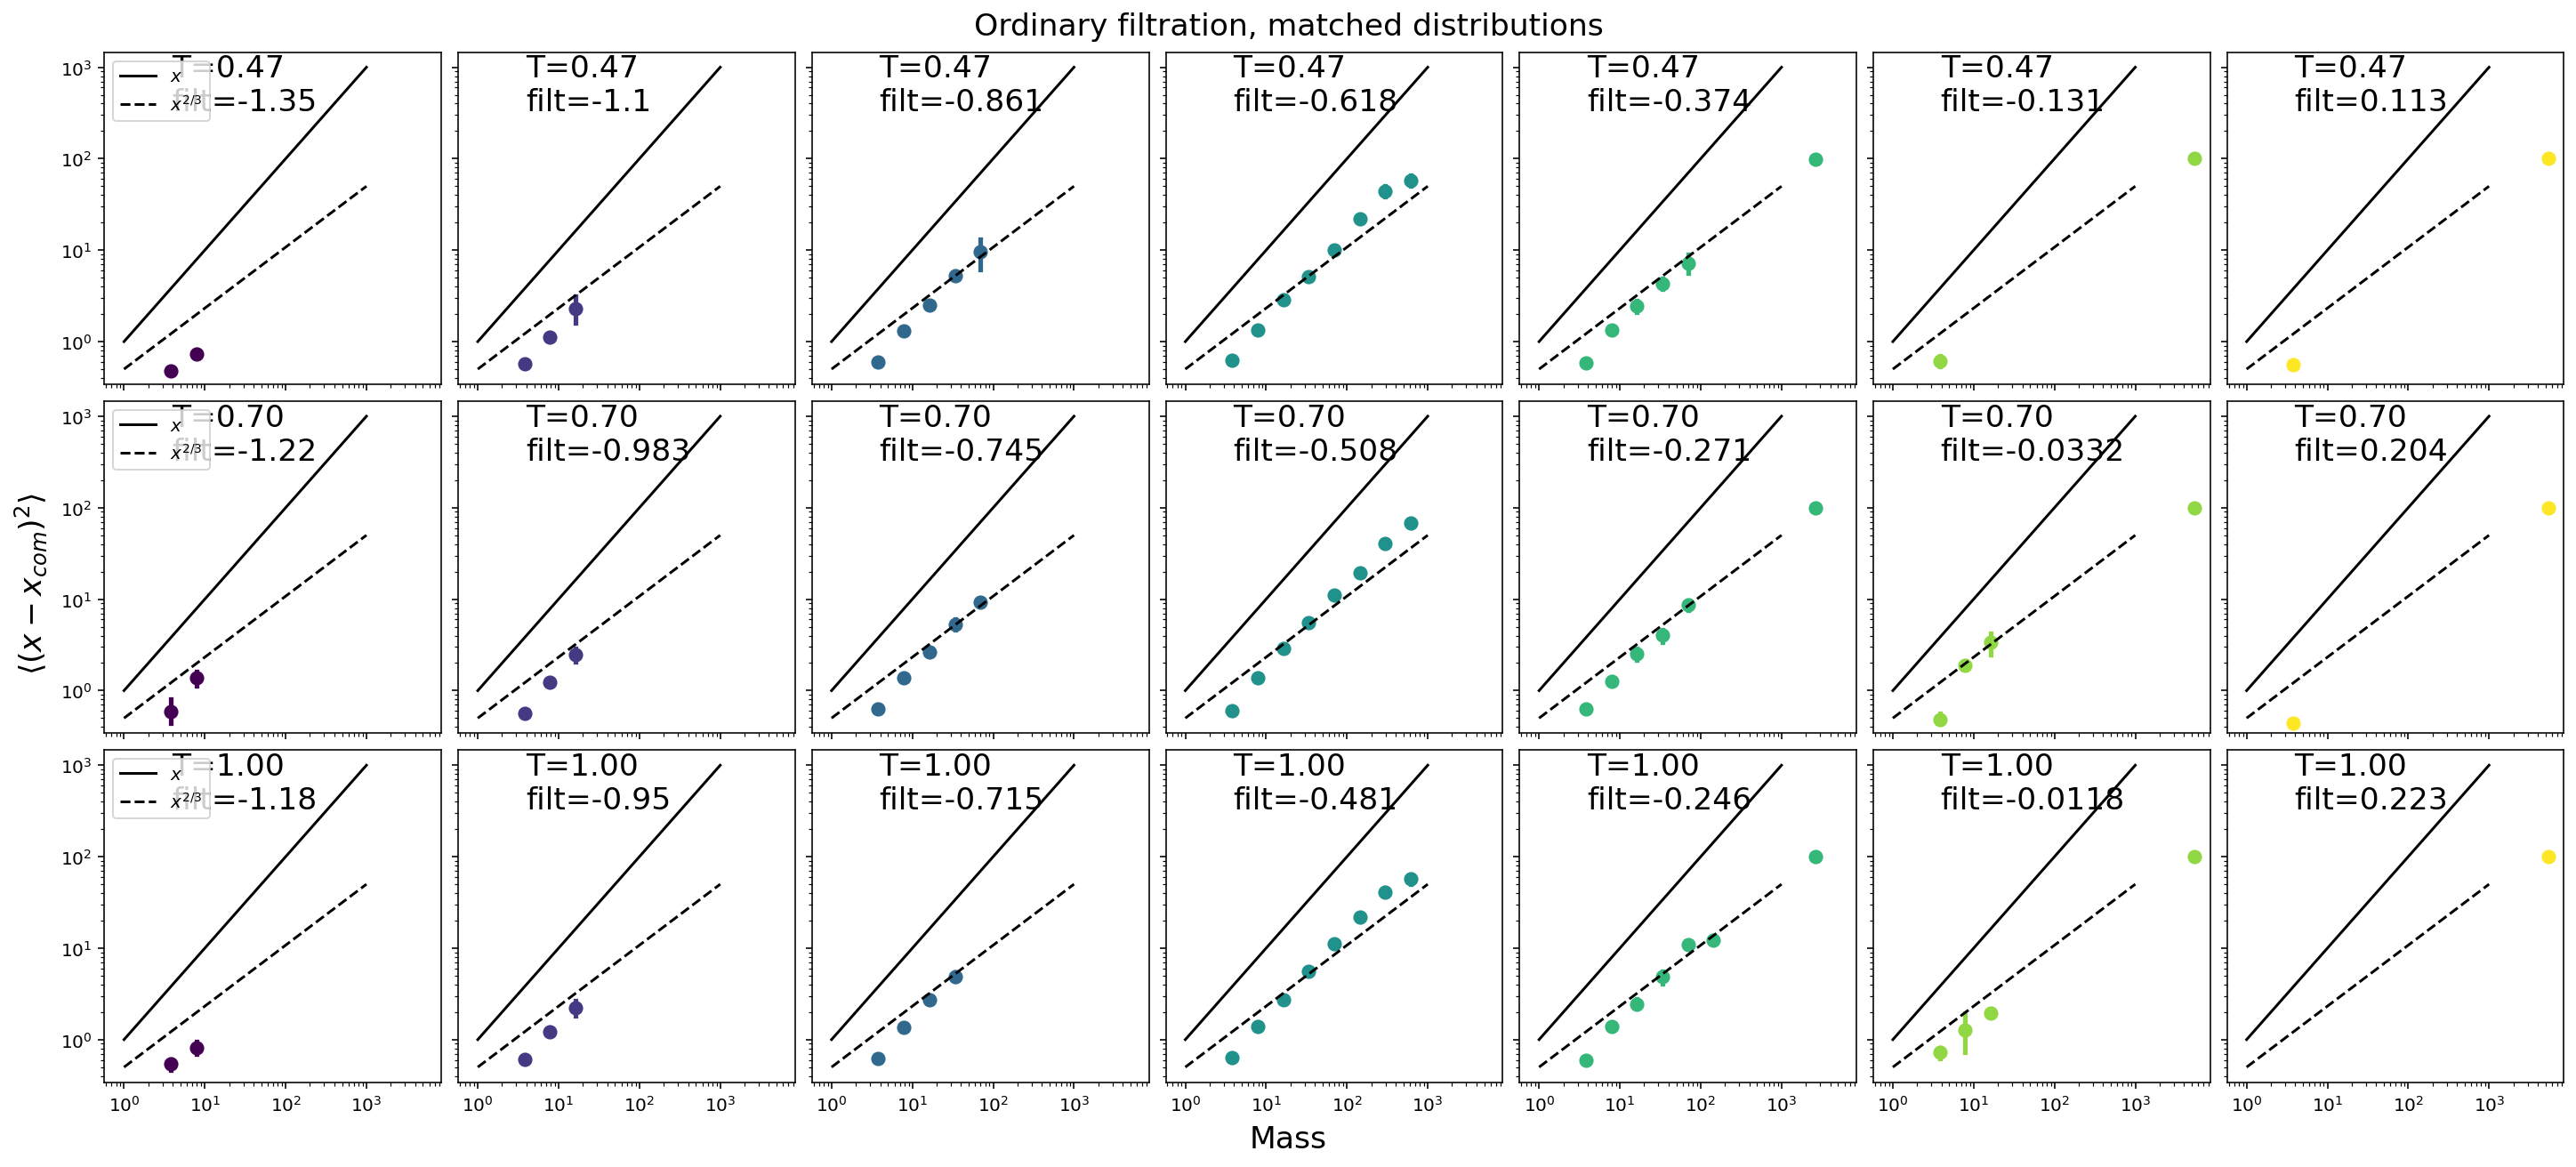

In [12]:
n_bins = 20
N = n_bins

output = defaultdict(list)

for delta, jobs_iter in project.find_jobs({"delta": 0.0}, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    job_bettis = []
    for job in jobs_iter:
        betti_curves = []
        temps = []
        for run_dir in sorted(glob.glob(job.fn("short_runs/temp-*"))):
            temp = float(utils.extract_between(run_dir, "temp-", "/"))
            # print(temp)
            # print(temp)
            if temp not in [0.47, 0.7, 1.0]:
                continue
            temps.append(temp)
            # print(temps[-1])
            run_dir = pathlib.Path(run_dir)
            # get softness dfb
            softness_df = pd.read_parquet(run_dir / "struct-descr.parquet")
            # get traj
            traj = gsd.hoomd.open(run_dir / "traj.gsd")

            for frame in softness_df["frame"].unique():
                grid = get_grid(traj, frame, softness_df, n_bins=n_bins, dims=(0,1,2))
                assert(not np.isnan(grid).any())
                output[temp].append(grid)
                
                # print(np.min(grid), np.max(grid))
                # process_grid(grid, np.linspace(-1.0, 0.0, 5, dtype=np.float32), axs=axs)


        
    break

fig, all_axs = plt.subplots(3, 7, figsize=(20, 9), layout='constrained', sharex=True, sharey=True)
# for ax in all_axs.ravel():
#     ax.set_aspect('equal', 'box')
idx = 0
for temp, grids in output.items():
    mean = np.mean(grids)
    std = np.std(grids)
    axs = all_axs[idx]

    filt = np.linspace(mean - std*3, mean + std*1, 7, dtype=np.float32)

    out = []
    for grid in grids:
        out.append(grid_process_step1(grid, filt, periodic=False))
    # print(out)

    x = np.geomspace(1e0, 1e3, 100)
    y = x
    y_root = 0.5*np.power(x, 2/3)
    
    
    grid_process_step2(out, filt, axs=axs)
    for jdx, ax in enumerate(axs):
        ax.plot(x, y, color="black", linestyle="-", label=r"$x$")
        ax.plot(x, y_root, color="black", linestyle="--", label=r"$x^{2/3}$")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.text(0.2, 0.9, f"T={temp:.2f}\nfilt={filt[jdx]:.3}", transform=ax.transAxes, horizontalalignment='left', verticalalignment='center', size="xx-large")
        
    idx += 1
    axs[0].legend()

fig.supxlabel("Mass", size="xx-large")
fig.supylabel(r"$\langle \left( x - x_{com} \right)^2 \rangle$", size="xx-large");
fig.suptitle("Ordinary filtration, matched distributions", size="xx-large");
fig.savefig("/home/ian/Pictures/distributions1.png", dpi=150);

In [7]:
tree = schmeud_locality.BlockTree(grid.astype(np.float32), True)

In [12]:
for f, a in zip(filt, tree.get_sites(filt)):
    for j in a:
        for k in j:
            for l in k:
                if l < 0 or l >= 20:
                    print(f, j)
                    break

-0.7152641 [(17.0, 8.0, 17.0), (18.0, 7.0, 16.0), (17.0, 8.0, 18.0), (17.0, 8.0, 19.0), (17.0, 9.0, 19.0), (17.0, 9.0, 20.0), (19.0, 7.0, 17.0), (19.0, 5.0, 17.0), (19.0, 8.0, 17.0), (17.0, 7.0, 17.0), (18.0, 7.0, 18.0), (18.0, 8.0, 17.0), (19.0, 8.0, 16.0), (18.0, 6.0, 17.0), (17.0, 7.0, 16.0), (18.0, 8.0, 16.0), (19.0, 6.0, 18.0), (19.0, 7.0, 18.0), (19.0, 6.0, 17.0), (18.0, 7.0, 17.0)]
-0.7152641 [(17.0, 19.0, 5.0), (18.0, 19.0, 4.0), (18.0, -20.0, 5.0), (17.0, 20.0, 5.0), (17.0, 19.0, 4.0)]
-0.7152641 [(17.0, 19.0, 5.0), (18.0, 19.0, 4.0), (18.0, -20.0, 5.0), (17.0, 20.0, 5.0), (17.0, 19.0, 4.0)]
-0.7152641 [(19.0, 3.0, 10.0), (19.0, 4.0, 10.0), (20.0, 3.0, 9.0), (19.0, 3.0, 9.0), (20.0, 3.0, 10.0), (20.0, 2.0, 9.0)]
-0.7152641 [(19.0, 3.0, 10.0), (19.0, 4.0, 10.0), (20.0, 3.0, 9.0), (19.0, 3.0, 9.0), (20.0, 3.0, 10.0), (20.0, 2.0, 9.0)]
-0.7152641 [(19.0, 3.0, 10.0), (19.0, 4.0, 10.0), (20.0, 3.0, 9.0), (19.0, 3.0, 9.0), (20.0, 3.0, 10.0), (20.0, 2.0, 9.0)]
-0.7152641 [(17.0, 0.0,

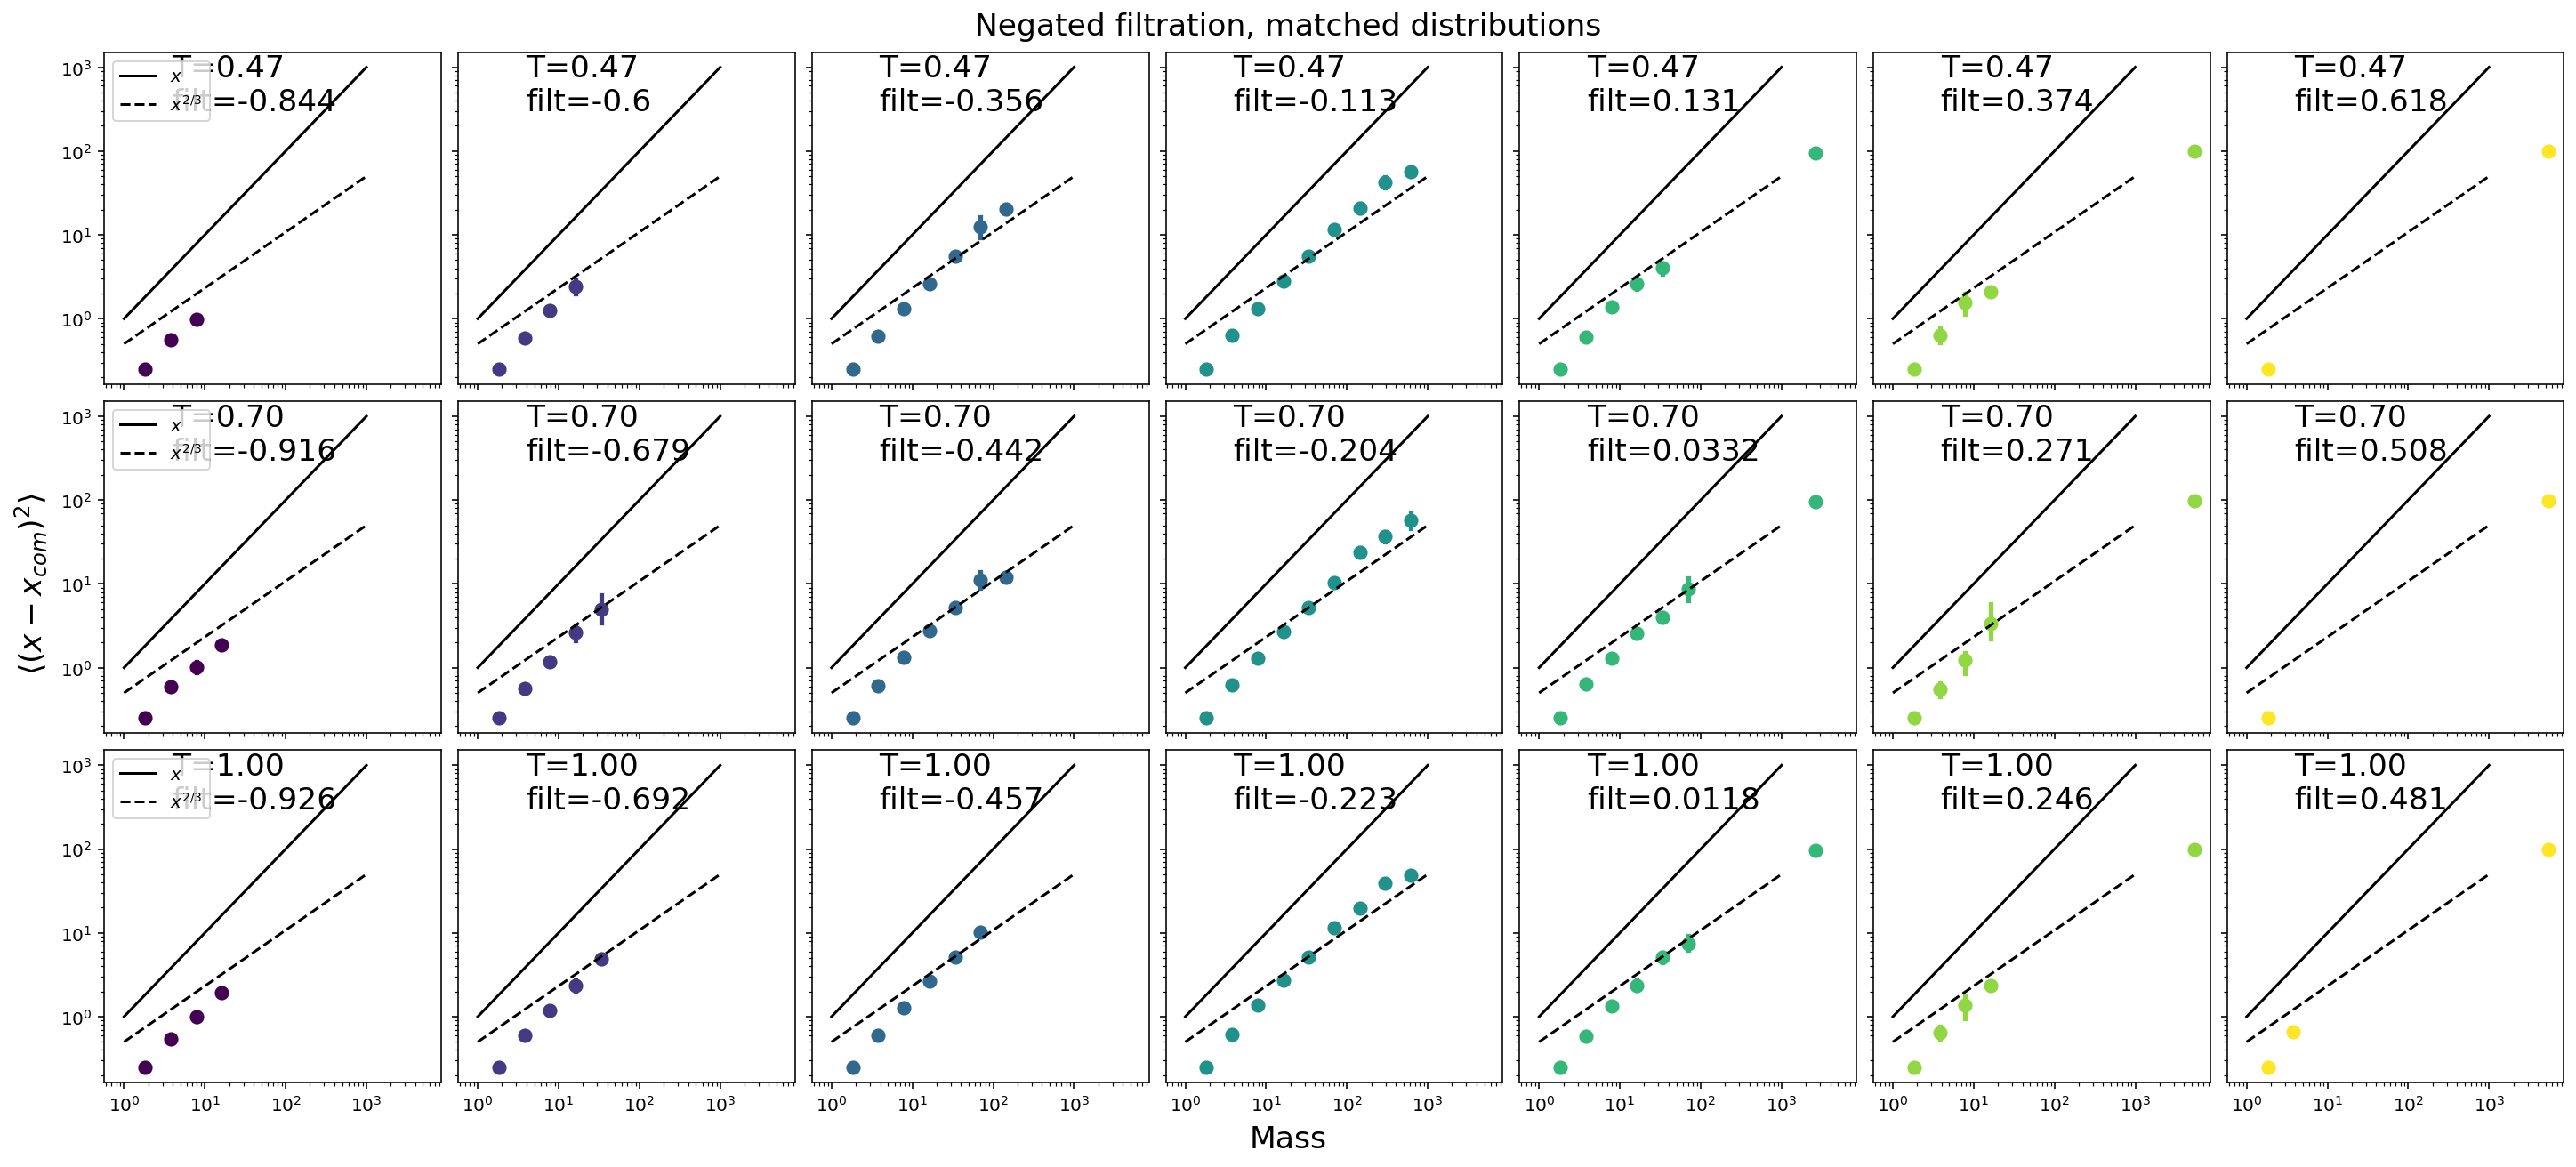

In [13]:
n_bins = 20
N = n_bins

output = defaultdict(list)

for delta, jobs_iter in project.find_jobs({"delta": 0.0}, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    job_bettis = []
    for job in jobs_iter:
        betti_curves = []
        temps = []
        for run_dir in sorted(glob.glob(job.fn("short_runs/temp-*"))):
            temp = float(utils.extract_between(run_dir, "temp-", "/"))
            # print(temp)
            if temp not in [0.47, 0.7, 1.0]:
                continue
            temps.append(temp)
            # print(temps[-1])
            run_dir = pathlib.Path(run_dir)
            # get softness dfb
            softness_df = pd.read_parquet(run_dir / "struct-descr.parquet")
            # get traj
            traj = gsd.hoomd.open(run_dir / "traj.gsd")

            for frame in softness_df["frame"].unique():
                grid = get_grid(traj, frame, softness_df, n_bins=n_bins, dims=(0,1,2), neg=True)
                assert(not np.isnan(grid).any())
                output[temp].append(grid)
                
                # print(np.min(grid), np.max(grid))
                # process_grid(grid, np.linspace(-1.0, 0.0, 5, dtype=np.float32), axs=axs)


        
    break


fig, all_axs = plt.subplots(3, 7, figsize=(20, 9), layout='constrained', sharex=True, sharey=True)
# for ax in all_axs.ravel():
#     ax.set_aspect('equal', 'box')
idx = 0
for temp, grids in output.items():
    mean = np.mean(grids)
    std = np.std(grids)
    axs = all_axs[idx]

    filt = np.linspace(mean - std*3, mean + std*1, 7, dtype=np.float32)

    out = []
    for grid in grids:
        out.append(grid_process_step1(grid, filt, periodic=False))
    # print(out)

    x = np.geomspace(1e0, 1e3, 100)
    y = x
    y_root = 0.5*np.power(x, 2/3)
    
    
    grid_process_step2(out, filt, axs=axs)
    for jdx, ax in enumerate(axs):
        ax.plot(x, y, color="black", linestyle="-", label=r"$x$")
        ax.plot(x, y_root, color="black", linestyle="--", label=r"$x^{2/3}$")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.text(0.2, 0.9, f"T={temp:.2f}\nfilt={filt[jdx]:.3}", transform=ax.transAxes, horizontalalignment='left', verticalalignment='center', size="xx-large")
        
    idx += 1
    axs[0].legend()

fig.supxlabel("Mass", size="xx-large")
fig.supylabel(r"$\langle \left( x - x_{com} \right)^2 \rangle$", size="xx-large");
fig.suptitle("Negated filtration, matched distributions", size="xx-large");
fig.savefig("/home/ian/Pictures/distributions2.png", dpi=150);

In [68]:
n_bins = 20
N = n_bins

output = defaultdict(list)

for delta, jobs_iter in project.find_jobs({"delta": 0.0}, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    job_bettis = []
    for job in jobs_iter:
        betti_curves = []
        temps = []
        for run_dir in sorted(glob.glob(job.fn("short_runs/temp-*"))):
            temp = float(utils.extract_between(run_dir, "temp-", "/"))
            # print(temp)
            if temp not in [0.47, 0.7, 1.0]:
                continue
            temps.append(temp)
            # print(temps[-1])
            run_dir = pathlib.Path(run_dir)
            # get softness dfb
            softness_df = pd.read_parquet(run_dir / "struct-descr.parquet")
            # get traj
            traj = gsd.hoomd.open(run_dir / "traj.gsd")

            for frame in softness_df["frame"].unique():
                grid = get_grid(traj, frame, softness_df, n_bins=n_bins, dims=(0,1,2), neg=True)
                assert(not np.isnan(grid).any())
                output[temp].append(grid)
                
                # print(np.min(grid), np.max(grid))
                # process_grid(grid, np.linspace(-1.0, 0.0, 5, dtype=np.float32), axs=axs)


        break
    break


array([-3.        , -2.3333333 , -1.6666666 , -1.        , -0.33333334,
        0.33333334,  1.        ], dtype=float32)